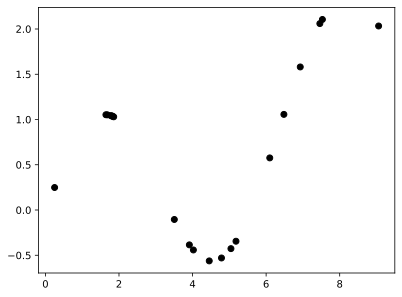

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = "svg"


def true_function(X):
    return np.sin(X) + (X / 7) ** 2


X = np.random.rand(20) * 10
y = true_function(X)

plt.plot(X, y, "ok")

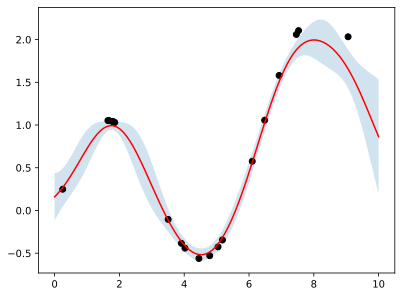

In [2]:
from mini_gpr.full import GPR
from mini_gpr.kernels import RBF

model = GPR(kernel=RBF(sigma=1.0), noise=3e-1)

model.fit(X, y)

xx = np.linspace(0, 10, 100)
yy, sigma_yy = model.predict(xx), model.uncertainty(xx)

plt.plot(X, y, "ok")
plt.plot(xx, yy, "-r")
plt.fill_between(xx, yy - sigma_yy, yy + sigma_yy, alpha=0.2)

In [3]:
from mini_gpr.sparse import SparseGPR

model = SparseGPR(kernel=RBF(sigma=1.0), noise=1e-10)

model.fit(X, y)

xx = np.linspace(0, 10, 100)
yy, sigma_yy = model.predict(xx), model.uncertainty(xx)

plt.plot(X, y, "ok")
plt.plot(xx, yy, "-r")
plt.fill_between(xx, yy - sigma_yy, yy + sigma_yy, alpha=0.2)

plt.plot(
    model.points,
    [1.05] * len(model.points),
    "vk",
    transform=plt.gca().get_xaxis_transform(),
    clip_on=False,
)

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (10,20)->(20,newaxis,10) (10,10)->(10,10) (10,20)->(10,20,newaxis) 

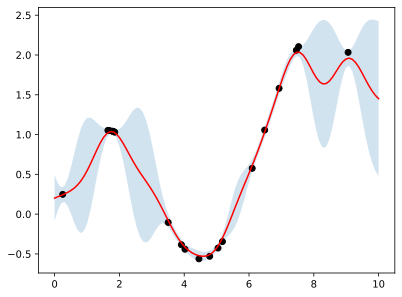

In [4]:
# create a pipeline model that first normalises the data and then fits a gpr model
from sklearn.linear_model import LinearRegression
from mini_gpr.utils import ModelStack

lr = LinearRegression()
gpr = GPR(kernel=RBF(sigma=0.5), noise=1e-1)

model = ModelStack(lr, gpr)
model.fit(X[:, None], y)


xx = np.linspace(0, 10, 100)
yy = model.predict(xx[:, None])
yy_std = gpr.uncertainty(xx[:, None])

plt.plot(X, y, "ok")
plt.plot(xx, yy, "-r")
plt.fill_between(xx, yy - yy_std, yy + yy_std, alpha=0.2);

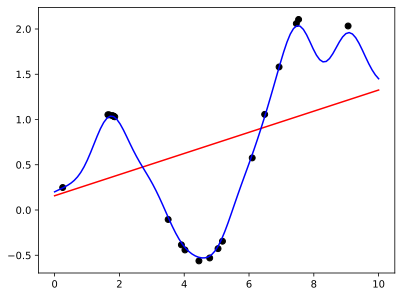

In [5]:
lr = LinearRegression()
gpr = GPR(kernel=RBF(sigma=0.5), noise=1e-1)

model = ModelStack(lr, gpr)
model.fit(X[:, None], y)


xx = np.linspace(0, 10, 100)
yy0 = model[0].predict(xx[:, None])
yy1 = model[1].predict(xx[:, None])

plt.plot(X, y, "ok")
plt.plot(xx, yy0, "-r")
plt.plot(xx, yy1 + yy0, "-b")

In [6]:
import numpy as np

def get_grid(xlim, ylim, N=100) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    x = np.linspace(xlim[0], xlim[1], N)
    y = np.linspace(ylim[0], ylim[1], N)
    mesh_x, mesh_y = np.meshgrid(x, y)
    return x, y, np.stack([mesh_x.ravel(), mesh_y.ravel()], axis=1)

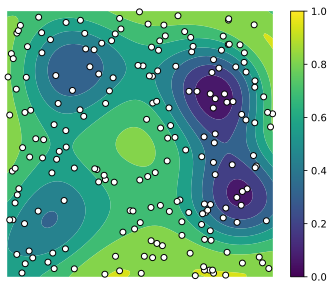

In [14]:
from jaxtyping import Float
from mini_gpr import auto_fit_gpr


def himmelblau(X: Float[np.ndarray, "A 2"]):
    x, y = X.T
    return np.log((x**2 + y - 11) ** 2 + (x + y**2 - 7) ** 2)


X_train = np.random.rand(200, 2) * 10 - 5
y_train = himmelblau(X_train)

model = auto_fit_gpr(X_train, y_train, lengthscale=2, noise=1e-1)

# test on grid of points
xx, yy, X_test = get_grid((-5, 5), (-5, 5))
y_test = model.predict(X_test)

plt.contourf(xx, yy, y_test.reshape(100, 100), cmap="viridis")
plt.scatter(*X_train.T, c="w", edgecolors="k", clip_on=False)
plt.gca().set_aspect("equal")
plt.axis("off")
plt.colorbar()